In [243]:
import warnings

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_error
import math

In [247]:
# Holidays relevant to retail: ['Namorados', 'Crianças', 'Black Friday', 'Natal', 'Mulher']
holidays = pd.to_datetime(['2016-06-12', '2016-10-12', '2016-11-24', '2016-12-25', '2017-03-08'])

def plot_holidays(cluster, holidays):
    holidays_in_dataset = [holiday for holiday in holidays if holiday in cluster.index.tolist()]
    for holiday in holidays_in_dataset:
        plt.axvline(x=holiday, color='r', label=holiday, ls = 'dashed')

In [329]:
train = pd.read_csv('train_clustered.csv')
test = pd.read_csv('test_clustered.csv')

# train = pd.to_datetime(train.index)
# test = pd.to_datetime(test.index)

In [386]:
full_sales = pd.concat([train, test])
full_sales.index = pd.to_datetime(full_sales.sale_date)
full_sales = full_sales.drop('sale_date', axis = 1)

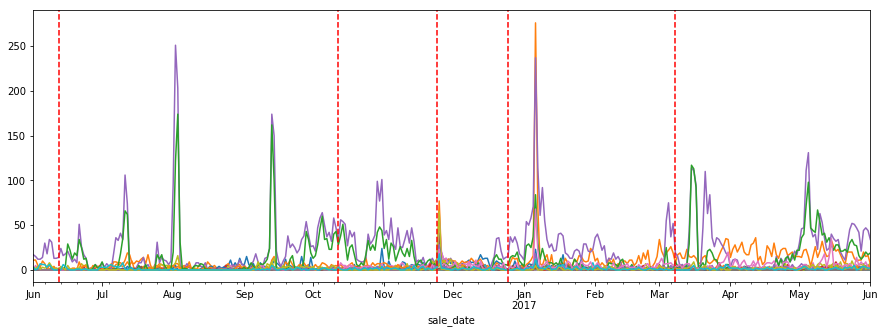

In [387]:
q_full_sales = full_sales.pivot_table(values='quantity', index=['sale_date'], columns=['code'], aggfunc=np.sum).fillna(0)
q_full_sales.plot(figsize=(15, 5), legend = False)
plot_holidays(q_full_sales, holidays)

In [332]:
train['labels'].value_counts()

12    8664
9     7668
8     4114
10     277
20     137
15      72
19      33
13      28
6       23
11      20
18      14
4       11
1        8
16       6
5        5
14       4
7        4
17       4
3        1
Name: labels, dtype: int64

In [333]:
sorted_labels = train['labels'].value_counts().index

In [334]:
cluster_a = train[train['labels'] == sorted_labels[0]]
cluster_b = train[train['labels'] == sorted_labels[1]]
cluster_c = train[train['labels'] == sorted_labels[2]]

cluster_others = train[train['labels'].isin(sorted_labels[3:])]

In [335]:
cluster_a = pd.pivot_table(cluster_a, values='quantity', index=['sale_date'], aggfunc=np.sum).fillna(0)
cluster_b = pd.pivot_table(cluster_b, values='quantity', index=['sale_date'], aggfunc=np.sum).fillna(0)
cluster_c = pd.pivot_table(cluster_c, values='quantity', index=['sale_date'], aggfunc=np.sum).fillna(0)
cluster_others = pd.pivot_table(cluster_others, values='quantity', index=['sale_date'], aggfunc=np.sum).fillna(0)

In [336]:
cluster_a.name = 'cluster_a'
cluster_b.name = 'cluster_b'
cluster_c.name = 'cluster_c'
cluster_others.name = 'cluster_others'

In [337]:
cluster_a.index = pd.to_datetime(cluster_a.index)
cluster_b.index = pd.to_datetime(cluster_b.index)
cluster_c.index = pd.to_datetime(cluster_c.index)
cluster_others.index = pd.to_datetime(cluster_others.index)

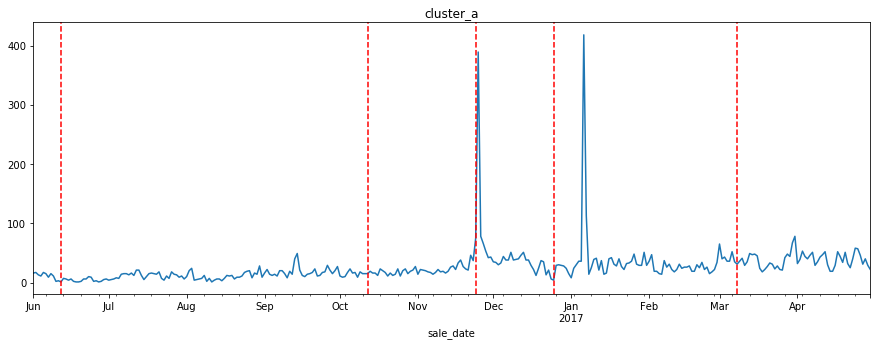

In [338]:
cluster_a.plot(figsize=(15, 5), legend=False, title = cluster_a.name)
plot_holidays(cluster_a, holidays)

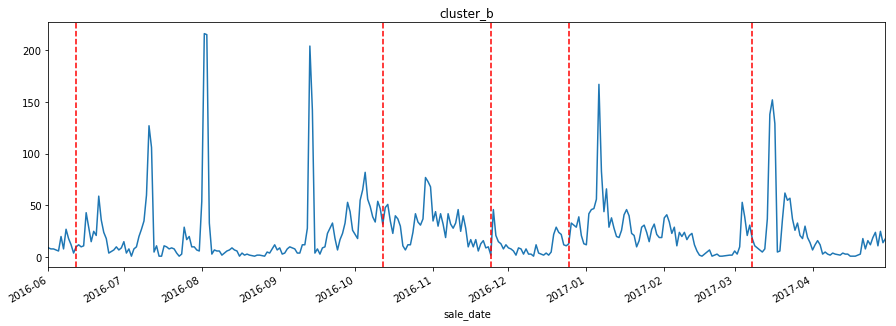

In [339]:
cluster_b.plot(figsize=(15, 5), legend=False, title = cluster_b.name)
plot_holidays(cluster_b, holidays)

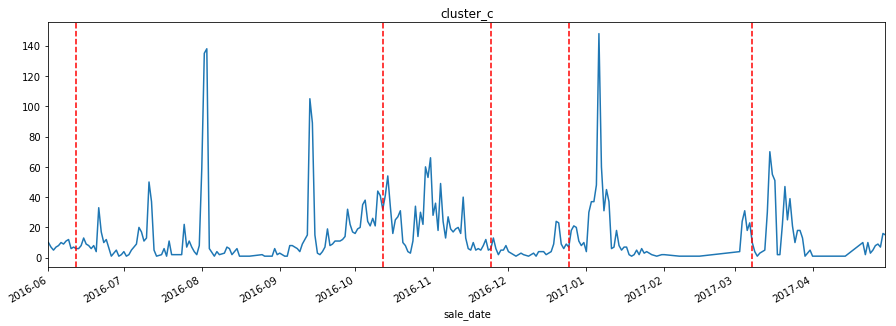

In [340]:
cluster_c.plot(figsize=(15, 5), legend=False, title = cluster_c.name)
plot_holidays(cluster_c, holidays)

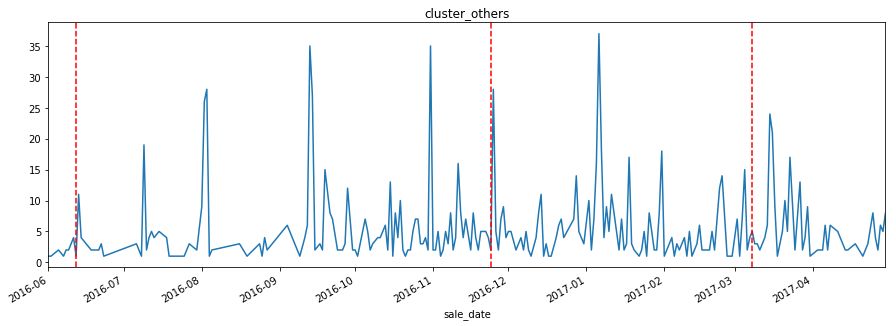

In [341]:
cluster_others.plot(figsize=(15, 5), legend=False, title = cluster_others.name)
plot_holidays(cluster_others, holidays)

### Testando stationarity em vendas diárias

In [342]:
def is_stationary(cluster):
    # hopeffuly the dataset is log transformed, more linear, more compliant with Dickey–Fuller expectations
    result = adfuller(cluster.quantity.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    adf_result = 'stationary' if result[1] <= 0.05 else 'non-stationary'
    print('{} is {}'.format(cluster.name, adf_result))

In [343]:
is_stationary(cluster_a)

ADF Statistic: -7.620444
p-value: 2.1354986299e-11
Critical Values:
	5%: -2.870
	1%: -3.450
	10%: -2.571
cluster_a is stationary


In [344]:
is_stationary(cluster_b)

ADF Statistic: -7.761872
p-value: 9.40778021397e-12
Critical Values:
	5%: -2.871
	1%: -3.451
	10%: -2.572
cluster_b is stationary


In [345]:
is_stationary(cluster_c)

ADF Statistic: -8.379546
p-value: 2.53190642257e-13
Critical Values:
	5%: -2.872
	1%: -3.455
	10%: -2.573
cluster_c is stationary


In [346]:
is_stationary(cluster_others)

ADF Statistic: -10.247978
p-value: 4.56419843756e-18
Critical Values:
	5%: -2.874
	1%: -3.459
	10%: -2.573
cluster_others is stationary


### Tratar non-stationarity das vendas mensais

In [347]:
cluster_a_log_diff = np.log(cluster_a).diff().dropna()
cluster_b_log_diff = np.log(cluster_b).diff().dropna()
cluster_c_log_diff = np.log(cluster_c).diff().dropna()
cluster_others_log_diff = np.log(cluster_others).diff().dropna()

In [348]:
cluster_a_log_diff.name = 'cluster_a_log_diff'
cluster_b_log_diff.name = 'cluster_b_log_diff'
cluster_c_log_diff.name = 'cluster_c_log_diff'
cluster_others_log_diff.name = 'cluster_others_log_diff'

In [349]:
cluster_a_log_diff.index = pd.to_datetime(cluster_a_log_diff.index)
cluster_b_log_diff.index = pd.to_datetime(cluster_b_log_diff.index)
cluster_c_log_diff.index = pd.to_datetime(cluster_c_log_diff.index)
cluster_others_log_diff.index = pd.to_datetime(cluster_others_log_diff.index)

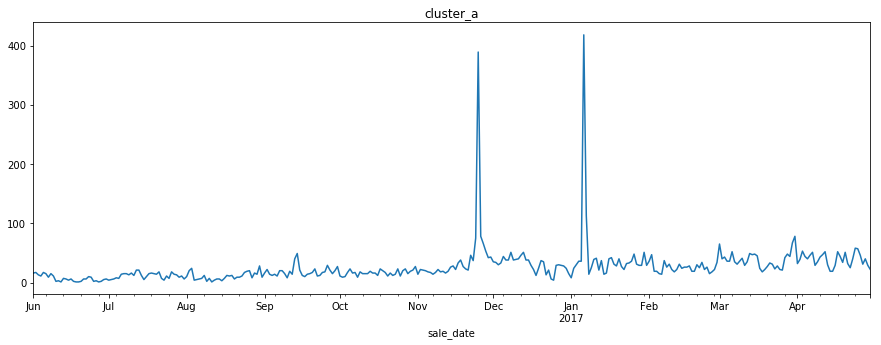

In [350]:
cluster_a.plot(figsize=(15, 5), legend=False, title = cluster_a.name)

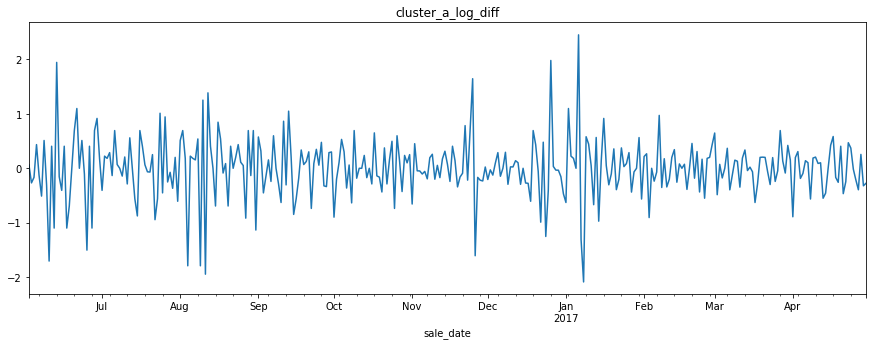

In [351]:
cluster_a_log_diff.plot(figsize=(15, 5), legend=False, title = cluster_a.name + '_log_diff')

In [352]:
is_stationary(cluster_a_log_diff)

ADF Statistic: -13.339836
p-value: 5.95056908453e-25
Critical Values:
	5%: -2.870
	1%: -3.451
	10%: -2.572
cluster_a_log_diff is stationary


In [353]:
is_stationary(cluster_b_log_diff)

ADF Statistic: -11.261333
p-value: 1.6192772736e-20
Critical Values:
	5%: -2.871
	1%: -3.451
	10%: -2.572
cluster_b_log_diff is stationary


In [354]:
is_stationary(cluster_c_log_diff)

ADF Statistic: -11.041199
p-value: 5.36054339304e-20
Critical Values:
	5%: -2.872
	1%: -3.455
	10%: -2.573
cluster_c_log_diff is stationary


In [355]:
is_stationary(cluster_others_log_diff)

ADF Statistic: -9.193439
p-value: 2.09326158167e-15
Critical Values:
	5%: -2.875
	1%: -3.460
	10%: -2.574
cluster_others_log_diff is stationary


### Os clusters já eram stationary. Não é preciso utilizar o log_diff

### Verificar Auto-Correlação e Auto-Correlação Parcial

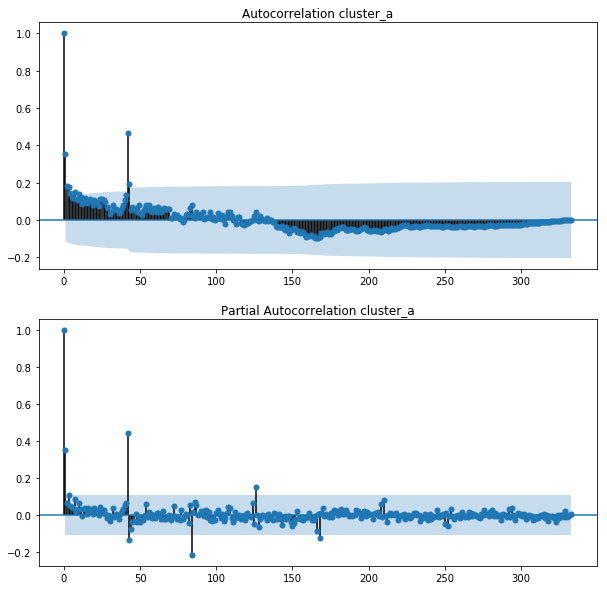

In [356]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plot_acf(cluster_a, ax=plt.gca(), title='Autocorrelation ' + cluster_a.name)
plt.subplot(212)
plot_pacf(cluster_a, ax=plt.gca(), title='Partial Autocorrelation ' + cluster_a.name)
plt.show()

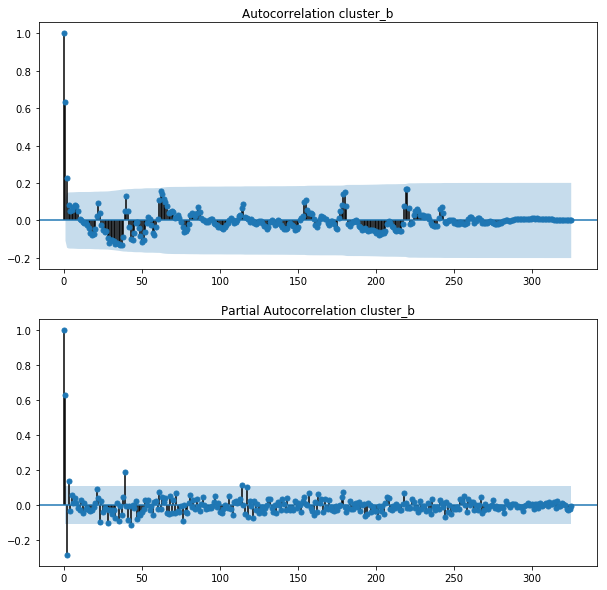

In [357]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plot_acf(cluster_b, ax=plt.gca(), title='Autocorrelation ' + cluster_b.name)
plt.subplot(212)
plot_pacf(cluster_b, ax=plt.gca(), title='Partial Autocorrelation ' + cluster_b.name)
plt.show()

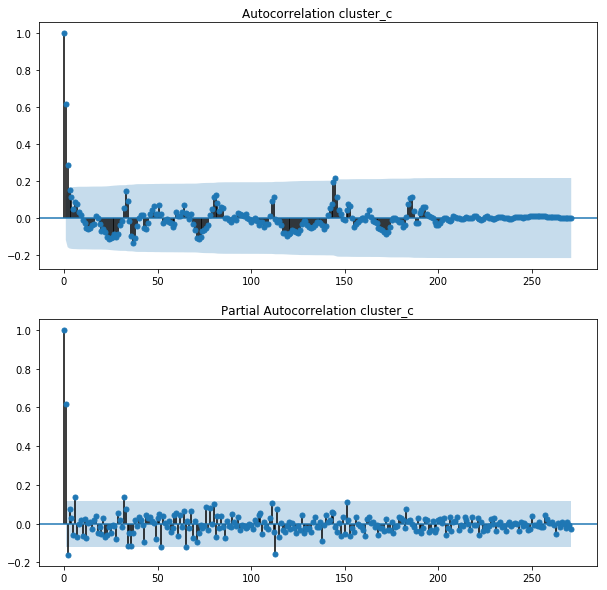

In [358]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plot_acf(cluster_c, ax=plt.gca(), title='Autocorrelation ' + cluster_c.name)
plt.subplot(212)
plot_pacf(cluster_c, ax=plt.gca(), title='Partial Autocorrelation ' + cluster_c.name)
plt.show()

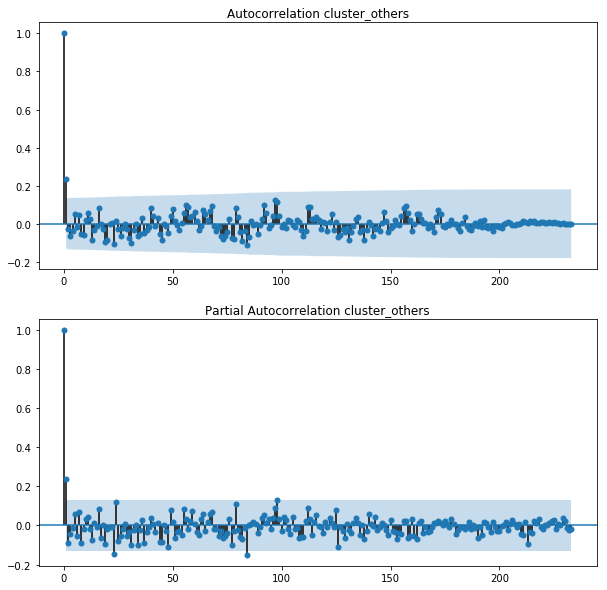

In [359]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plot_acf(cluster_others, ax=plt.gca(), title='Autocorrelation ' + cluster_others.name)
plt.subplot(212)
plot_pacf(cluster_others, ax=plt.gca(), title='Partial Autocorrelation ' + cluster_others.name)
plt.show()

# Uso do ARIMA para previsão

In [360]:
def evaluate_arima_model(train, test, arima_order):
    # make predictions
    
    arima = ARIMA(train.astype('float32'), order=arima_order).fit()
    predictions = arima.forecast(len(test))[0]
    #     for t in range(len(test)):
    #         # difference data
    #         model = ARIMA(train[t:], order=arima_order)
    #         model_fit = model.fit(trend='nc', disp=0)
    #         yhat = model_fit.forecast()[0]
    #         predictions.append(yhat)
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = math.sqrt(mse)
    return rmse, predictions

In [361]:
def evaluate_models(train, test, p_values, d_values, q_values):
    # evaluate combinations of p, d and q values for an ARIMA model
    best_score, best_cfg, predictions = float("inf"), None, []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse, predictions = evaluate_arima_model(train, test, order)
                    if mse < best_score:
                        best_score, best_cfg, best_prediction = mse, order, predictions
                        print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score, best_prediction

In [362]:
test_cluster_a = test[test['labels'] == sorted_labels[0]]
test_cluster_b = test[test['labels'] == sorted_labels[1]]
test_cluster_c = test[test['labels'] == sorted_labels[2]]

test_cluster_others = test[test['labels'].isin(sorted_labels[3:])]

In [363]:
test_cluster_a = pd.pivot_table(test_cluster_a, values='quantity', index=['sale_date'], aggfunc=np.sum).fillna(0)
test_cluster_b = pd.pivot_table(test_cluster_b, values='quantity', index=['sale_date'], aggfunc=np.sum).fillna(0)
test_cluster_c = pd.pivot_table(test_cluster_c, values='quantity', index=['sale_date'], aggfunc=np.sum).fillna(0)
test_cluster_others = pd.pivot_table(test_cluster_others, values='quantity', index=['sale_date'], aggfunc=np.sum).fillna(0)

In [364]:
test_cluster_a.name = 'test_cluster_a'
test_cluster_b.name = 'test_cluster_b'
test_cluster_c.name = 'test_cluster_c'
test_cluster_others.name = 'test_cluster_others'

In [365]:
test_cluster_a.index = pd.to_datetime(test_cluster_a.index)
test_cluster_b.index = pd.to_datetime(test_cluster_b.index)
test_cluster_c.index = pd.to_datetime(test_cluster_c.index)
test_cluster_others.index = pd.to_datetime(test_cluster_others.index)

In [366]:
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)

In [367]:
# cluster_a forecasting
warnings.filterwarnings("ignore")
best_cfg_a, best_score_a, best_prediction_a = evaluate_models(cluster_a.quantity.values, test_cluster_a.quantity.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=22.379
ARIMA(0, 1, 1) RMSE=13.273
ARIMA(0, 1, 2) RMSE=12.808
ARIMA(4, 1, 5) RMSE=12.515
ARIMA(5, 1, 5) RMSE=12.431
Best ARIMA(5, 1, 5) RMSE=12.431


In [368]:
# cluster_b forecasting
warnings.filterwarnings("ignore")
best_cfg_b, best_score_b, best_prediction_b = evaluate_models(cluster_b.quantity.values, test_cluster_b.quantity.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=34.284
ARIMA(0, 0, 1) RMSE=34.271
ARIMA(1, 2, 0) RMSE=33.914
ARIMA(2, 0, 2) RMSE=30.760
ARIMA(5, 0, 4) RMSE=30.544
Best ARIMA(5, 0, 4) RMSE=30.544


In [369]:
# cluster_c forecasting
warnings.filterwarnings("ignore")
best_cfg_c, best_score_c, best_prediction_c = evaluate_models(cluster_c.quantity.values, test_cluster_c.quantity.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=19.011
ARIMA(0, 1, 0) RMSE=18.969
ARIMA(0, 1, 3) RMSE=18.656
ARIMA(0, 1, 4) RMSE=18.656
ARIMA(1, 1, 1) RMSE=18.646
ARIMA(2, 1, 1) RMSE=18.632
ARIMA(3, 1, 6) RMSE=18.463
ARIMA(4, 0, 3) RMSE=16.932
ARIMA(6, 0, 6) RMSE=15.494
Best ARIMA(6, 0, 6) RMSE=15.494


In [370]:
# cluster_others forecasting
warnings.filterwarnings("ignore")
best_cfg_others, best_score_others, best_prediction_others = evaluate_models(cluster_others.quantity.values, test_cluster_others.quantity.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=4.789
ARIMA(0, 1, 1) RMSE=4.762
ARIMA(0, 2, 1) RMSE=4.716
ARIMA(1, 0, 2) RMSE=4.582
ARIMA(2, 0, 1) RMSE=4.545
ARIMA(6, 0, 2) RMSE=4.517
ARIMA(6, 0, 3) RMSE=4.298
Best ARIMA(6, 0, 3) RMSE=4.298


### Agora observamos os erros residuais
- Espera-se, idealmente, que os erros residuais sigam uma gaussiana padrão (média em 0)
- Observando a autocorrelação dos erros residuais, busca-se saber se ainda há mais oportunidades de modelar tendências temporais nos dados

In [371]:
re_cluster_a = test_cluster_a.quantity - best_prediction_a
re_cluster_b = test_cluster_b.quantity - best_prediction_b
re_cluster_c = test_cluster_c.quantity - best_prediction_c
re_cluster_others = test_cluster_others.quantity - best_prediction_others

Distribuição dos Erros Residuais no Cluster A
count    32.000000
mean     -1.679544
std      12.514439
min     -25.264160
25%      -8.353190
50%      -1.825423
75%       3.419164
max      43.308456
Name: quantity, dtype: float64


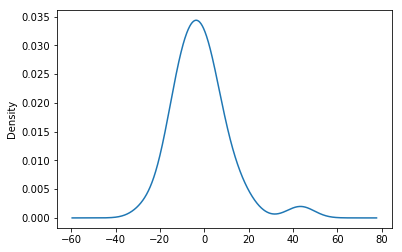

In [372]:
print('Distribuição dos Erros Residuais no Cluster A')
print(re_cluster_a.describe())
re_cluster_a.plot(kind='kde', ax=plt.gca())

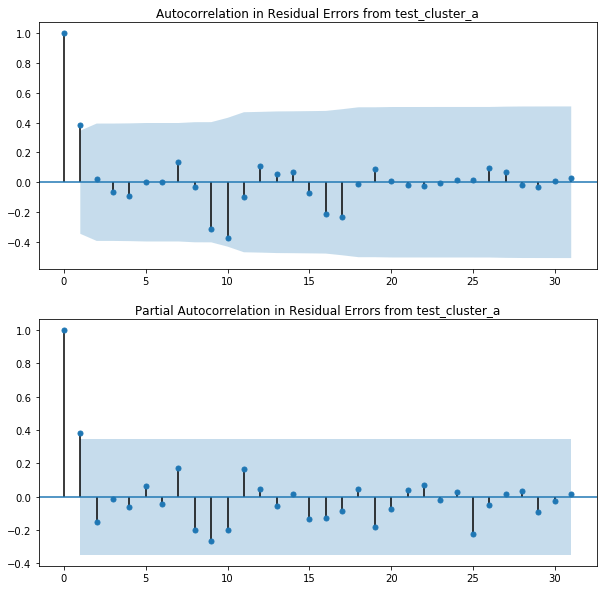

In [373]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plot_acf(re_cluster_a, ax=plt.gca(), title='Autocorrelation in Residual Errors from ' + test_cluster_a.name)
plt.subplot(212)
plot_pacf(re_cluster_a, ax=plt.gca(), title='Partial Autocorrelation in Residual Errors from ' + test_cluster_a.name)
plt.show()

Distribuição dos Erros Residuais no Cluster B
count     32.000000
mean      20.194882
std       23.282460
min       -9.099620
25%        7.063866
50%       16.052594
75%       25.567714
max      102.687125
Name: quantity, dtype: float64


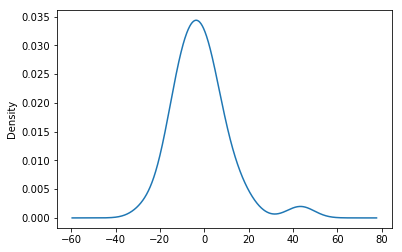

In [374]:
print('Distribuição dos Erros Residuais no Cluster B')
print(re_cluster_b.describe())
re_cluster_a.plot(kind='kde', ax=plt.gca())

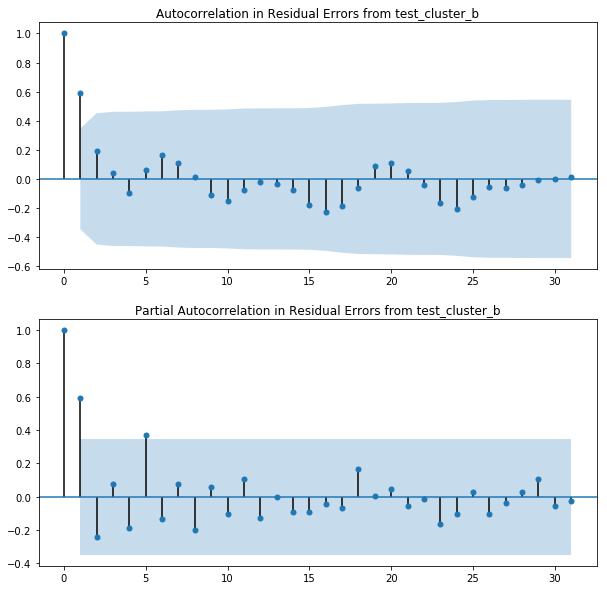

In [375]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plot_acf(re_cluster_b, ax=plt.gca(), title='Autocorrelation in Residual Errors from ' + test_cluster_b.name)
plt.subplot(212)
plot_pacf(re_cluster_b, ax=plt.gca(), title='Partial Autocorrelation in Residual Errors from ' + test_cluster_b.name)
plt.show()

Distribuição dos Erros Residuais no Cluster C
count    32.000000
mean      5.885828
std      14.561677
min      -8.234231
25%      -1.517436
50%       1.491929
75%       9.129760
max      65.467822
Name: quantity, dtype: float64


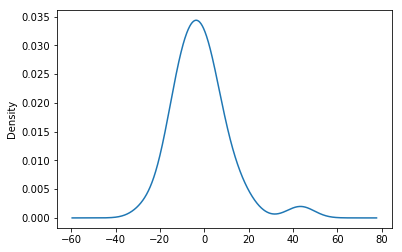

In [376]:
print('Distribuição dos Erros Residuais no Cluster C')
print(re_cluster_c.describe())
re_cluster_a.plot(kind='kde', ax=plt.gca())

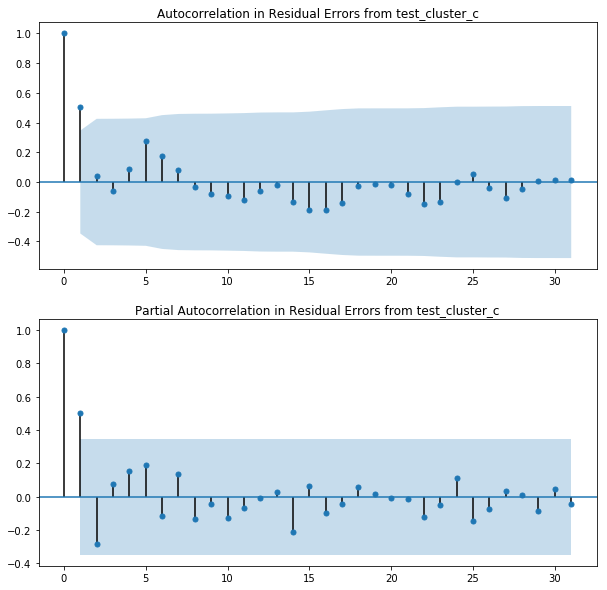

In [377]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plot_acf(re_cluster_c, ax=plt.gca(), title='Autocorrelation in Residual Errors from ' + test_cluster_c.name)
plt.subplot(212)
plot_pacf(re_cluster_c, ax=plt.gca(), title='Partial Autocorrelation in Residual Errors from ' + test_cluster_c.name)
plt.show()

Distribuição dos Erros Residuais no Cluster Others
count    29.000000
mean     -0.026367
std       4.373975
min      -4.537021
25%      -2.305866
50%      -0.689528
75%       0.533809
max      18.736887
Name: quantity, dtype: float64


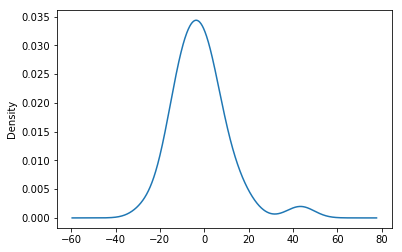

In [378]:
print('Distribuição dos Erros Residuais no Cluster Others')
print(re_cluster_others.describe())
re_cluster_a.plot(kind='kde', ax=plt.gca())

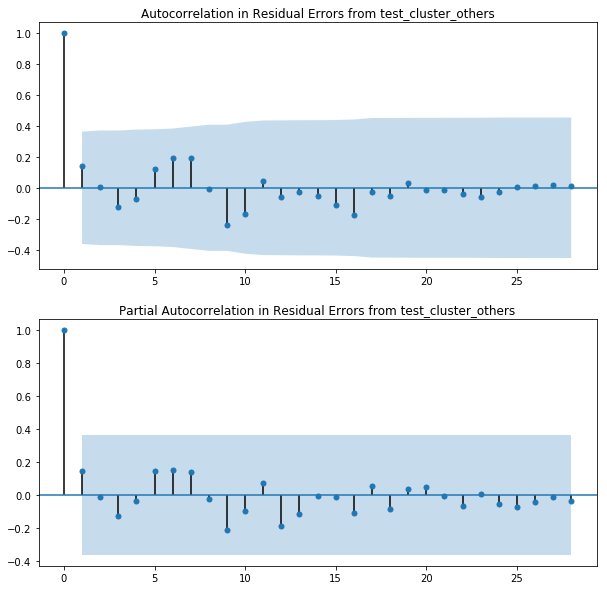

In [379]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plot_acf(re_cluster_others, ax=plt.gca(), title='Autocorrelation in Residual Errors from ' + test_cluster_others.name)
plt.subplot(212)
plot_pacf(re_cluster_others, ax=plt.gca(), title='Partial Autocorrelation in Residual Errors from ' + test_cluster_others.name)
plt.show()

# Aplicar os melhores fits a todo o banco de dados e fazer a previsão pedida no desafio

In [430]:
full_cluster_a = full_sales[full_sales['labels'] == sorted_labels[0]]
full_cluster_b = full_sales[full_sales['labels'] == sorted_labels[1]]
full_cluster_c = full_sales[full_sales['labels'] == sorted_labels[2]]

full_cluster_others = full_sales[full_sales['labels'].isin(sorted_labels[3:])]

In [431]:
full_cluster_a = pd.pivot_table(full_cluster_a, values='quantity', index=['sale_date'], columns=['code'], aggfunc=np.sum).fillna(0)
full_cluster_b = pd.pivot_table(full_cluster_b, values='quantity', index=['sale_date'], columns=['code'], aggfunc=np.sum).fillna(0)
full_cluster_c = pd.pivot_table(full_cluster_c, values='quantity', index=['sale_date'], columns=['code'], aggfunc=np.sum).fillna(0)
full_cluster_others = pd.pivot_table(full_cluster_others, values='quantity', index=['sale_date'], columns=['code'], aggfunc=np.sum).fillna(0)

In [432]:
full_cluster_a.name = 'full_cluster_a'
full_cluster_b.name = 'full_cluster_b'
full_cluster_c.name = 'full_cluster_c'
full_cluster_others.name = 'full_cluster_others'

In [433]:
full_cluster_a.index = pd.to_datetime(full_cluster_a.index)
full_cluster_b.index = pd.to_datetime(full_cluster_b.index)
full_cluster_c.index = pd.to_datetime(full_cluster_c.index)
full_cluster_others.index = pd.to_datetime(full_cluster_others.index)

In [434]:
q_cluster_a = pd.concat([cluster_a, test_cluster_a])
q_cluster_b = pd.concat([cluster_b, test_cluster_b])
q_cluster_c = pd.concat([cluster_c, test_cluster_c])
q_cluster_others = pd.concat([cluster_a, test_cluster_others])

In [435]:
forecasted_period = pd.date_range(start='2017-06-02', end='2017-08-31')
forecasted_quantities = pd.DataFrame(
    data=0, index = forecasted_period, columns = ['a', 'b', 'c', 'others'])

In [436]:
_, actual_prediction_a = evaluate_arima_model(q_cluster_a.quantity.values, forecasted_quantities.a.values, best_cfg_a)
_, actual_prediction_b = evaluate_arima_model(q_cluster_b.quantity.values, forecasted_quantities.b.values, best_cfg_b)
_, actual_prediction_c = evaluate_arima_model(q_cluster_c.quantity.values, forecasted_quantities.c.values, best_cfg_c)
_, actual_prediction_others = evaluate_arima_model(q_cluster_others.quantity.values, forecasted_quantities.others.values, best_cfg_others)

In [442]:
forecasted_quantities.a = actual_prediction_a
forecasted_quantities.b = actual_prediction_b
forecasted_quantities.c = actual_prediction_c
forecasted_quantities.others = actual_prediction_others

### Agora dividi-se o forecast pelo percentual inicical de quantidade de cada produto (code)

In [437]:
average_code__quantity_contribution_a = full_cluster_a.sum(axis=0) / full_cluster_a.sum(axis=0).sum()
average_code__quantity_contribution_b = full_cluster_b.sum(axis=0) / full_cluster_b.sum(axis=0).sum()
average_code__quantity_contribution_c = full_cluster_c.sum(axis=0) / full_cluster_c.sum(axis=0).sum()
average_code__quantity_contribution_others = full_cluster_others.sum(axis=0) / full_cluster_others.sum(axis=0).sum()
# q_percentages_a.mul(pd.Series(actual_prediction_a, index), axis=0)

In [514]:
forecasted_quantities_by_code_a = pd.DataFrame(1, index= forecasted_period, columns = full_sales.code.unique())
forecasted_quantities_by_code_a = forecasted_quantities_by_code_a * average_code__quantity_contribution_a
forecasted_quantities_by_code_a = forecasted_quantities_by_code_a.mul(actual_prediction_a, axis=0).apply(np.ceil, axis=1).fillna(0)

In [520]:
forecasted_quantities_by_code_b = pd.DataFrame(1, index= forecasted_period, columns = full_sales.code.unique())
forecasted_quantities_by_code_b = forecasted_quantities_by_code_b * average_code__quantity_contribution_b
forecasted_quantities_by_code_b = forecasted_quantities_by_code_b.mul(actual_prediction_b, axis=0).apply(np.ceil, axis=1).fillna(0)

In [521]:
forecasted_quantities_by_code_c = pd.DataFrame(1, index= forecasted_period, columns = full_sales.code.unique())
forecasted_quantities_by_code_c = forecasted_quantities_by_code_c * average_code__quantity_contribution_c
forecasted_quantities_by_code_c = forecasted_quantities_by_code_c.mul(actual_prediction_c, axis=0).apply(np.ceil, axis=1).fillna(0)

In [522]:
forecasted_quantities_by_code_others = pd.DataFrame(1, index= forecasted_period, columns = full_sales.code.unique())
forecasted_quantities_by_code_others = forecasted_quantities_by_code_others * average_code__quantity_contribution_others
forecasted_quantities_by_code_others = forecasted_quantities_by_code_others.mul(actual_prediction_others, axis=0).apply(np.ceil, axis=1).fillna(0)

In [523]:
forecasted_quantities_by_code = \
    forecasted_quantities_by_code_a.add(
        forecasted_quantities_by_code_b).add(
        forecasted_quantities_by_code_c).add(
        forecasted_quantities_by_code_others)

In [528]:
forecasted_quantities_by_code.to_csv('forecasted.csv', index=False)